In [1]:
using ITensors, ITensorMPS, Plots
using Plots.PlotMeasures
using HDF5

### Initial Parameters

In [2]:
N = 15 #Number of lattice sites per dimension
d = 2 #Number of spatial dimensions
a = 1 #Lattice spacing
sites = siteinds("Boson", N^d; dim=9) #ITensor sites
lat_site = Dict((x, y) => ((x-1)*N + y) for x in 1:N, y in 1:N) #Dictionary mapping lattice sites to ITensor sites

n_0 = round(Int, ((N-1)/2)) #Index of the point at the center of a lattice side.
dp = 2pi/(N*a) #Discrete change in momentum

mass = 0
p_max = ntuple(i -> n_0*dp, d)
p_xy = Array{Tuple{Float64, Float64}}(undef, N, N)
for x in 0:N-1
    for y in 0:N-1
        p_xy[x+1, y+1] = (-1 .* p_max) .+ ((x, y) .* dp)
    end
end

om_xy = Array{Float64}(undef, N, N)
for x in 0:N-1
    for y in 0:N-1
        p_x = (2/a)*sin(p_xy[x+1, y+1][1]*(a/2))
        p_y = (2/a)*sin(p_xy[x+1, y+1][2]*(a/2))
        om_xy[x+1, y+1] = sqrt((p_x)^2 + (p_y)^2 + mass^2)
    end
end

### Hamiltonian

In [3]:
H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for x in 1:N
    for y in 1:N
        i = lat_site[(x, y)]
        H += (dp/2pi)^d * om_xy[x, y], "a", i, "a†", i
        H += om_xy[x, y]*(1/2), "Id", i
    end
end

### Create the Vacuum State MPS

In [4]:
vac_state = ["0" for i in 1:N^d]
psi_gs = MPS(sites, vac_state);

### Define the Field Operator and Wilson Line Operators

In [5]:
function phi_n(m::Real, theta::Real) #Field value in the lightlike direction
    phi_lightlike = OpSum()
    for x in 1:N
        for y in 1:N
            i = lat_site[(x, y)]
            p_x, p_y = p_xy[x, y][1], p_xy[x, y][2]
            phi_lightlike += (1/sqrt(N))^d*(1/sqrt(2*om_xy[x, y]))*exp(-im*(p_x*cos(theta) + p_y*sin(theta) - om_xy[x, y])*m*a), "a", i #n*m*a = (1,1)*m*a = (m*a,m*a)
            phi_lightlike += (1/sqrt(N))^d*(1/sqrt(2*om_xy[x, y]))*exp(im*(p_x*cos(theta) + p_y*sin(theta) - om_xy[x, y])*m*a), "a†", i
        end
    end
    return phi_lightlike
end

function phi_nbar(m::Real, theta::Real) #Field value in the anti-lightlike direction
    phi_antilightlike = OpSum()
    for x in 1:N
        for y in 1:N
            i = lat_site[(x, y)]
            p_x, p_y = p_xy[x, y][1], p_xy[x, y][2]
            phi_antilightlike += (1/sqrt(N))^d*(1/sqrt(2*om_xy[x, y]))*exp(im*(p_x*cos(theta) + p_y*sin(theta) + om_xy[x, y])*m*a), "a", i #nbar*m*a = (1,-1)*m*a = (m*a,-m*a)
            phi_antilightlike += (1/sqrt(N))^d*(1/sqrt(2*om_xy[x, y]))*exp(-im*(p_x*cos(theta) + p_y*sin(theta) + om_xy[x, y])*m*a), "a†", i
        end
    end
    return phi_antilightlike
end

phi_nbar (generic function with 1 method)

In [6]:
function Y_n(g::Real, theta::Real)
    Y_n_op = OpSum()
    for m in 0:n_0
        Y_n_op += im*g*a*phi_n(m, theta)
    end
    return Y_n_op
end

function Y_nbar_dag(g::Real, theta::Real)
    Y_nbar_dag_op = OpSum()
    for m in 0:n_0
        Y_nbar_dag_op += -im*g*a*phi_nbar(m, theta)
    end
    return Y_nbar_dag_op
end

function YnbdYn(g::Real, theta::Real)
    return MPO(Y_nbar_dag(g, theta)+Y_n(g, theta), sites)
end

YnbdYn (generic function with 1 method)

### Prepare for Data Collection

In [7]:
t_range = range(0, stop=200, length=201) #Range of the timesteps
g_list = [0.5] #List of coupling constant values
theta_list = [pi/4, pi/4] #List of lightlike direction angles for each Wilson line operator
cutoff_list = [1e-15] #List of TDVP cutoff parameters for each value of g
if N > 14 #If N > 14, increase the threshold for ITensor's contraction warning
    ITensors.set_warn_order(N)
    ITensors.set_warn_order(N)
else #Else, reset the warning threshold to the default number of contractions, 14
    ITensors.set_warn_order(14)
    ITensors.set_warn_order(14)
end

15

In [8]:
#= SF_data = h5open("Soft_Function_data.h5", "r+") #Open the Soft Function data HDF5 file in read/write mode
if haskey(SF_data, "N=$N, m=$mass, dp=$dp") == false #Check if the "N=$N, m=$mass, dp=$dp" group doesn't exist
    create_group(SF_data, "N=$N, m=$mass, dp=$dp") #Create a group within the HDF5 file corresponding to the initial parameters
end
SF_data_group = SF_data["N=$N, m=$mass, dp=$dp"]

SF_MPS = h5open("Soft_Function_MPS.h5", "r+")
if haskey(SF_MPS, "N=$N, m=$mass, dp=$dp") == false
    create_group(SF_MPS, "N=$N, m=$mass, dp=$dp")
end
SF_MPS_group = SF_MPS["N=$N, m=$mass, dp=$dp"]; =#

### Calculate S(t)

In [9]:
#Create the states |Psi_0> = Y_nbar^dag(0)Y_n(0)|Ω> and |Psi_t> = e^{iHt}Y_nbar^dag(0)Y_n(0)e^{-iHt}|Ω> for some value of g and t
function MakeStates(g, theta_list, t, cutoff)
    Psi_0 = tdvp(YnbdYn(g, theta_list[1]), 1, psi_gs; nsteps=1, maxdim=200, cutoff=cutoff, normalize=true) #tdvp calculates exp(op*t)|psi>. By setting t=1, tdvp reduces to exp(op)|psi>
    
    psi_t = tdvp(MPO(-im*H, sites), t, psi_gs; nsteps=1, maxdim=200, cutoff=cutoff, normalize=true) #Time evolve the ground state
    psi_t = tdvp(YnbdYn(g, theta_list[2]), 1, psi_t; nsteps=1, maxdim=200, cutoff=cutoff, normalize=true) #Apply the Wilson line operator
    Psi_t = tdvp(MPO(im*H, sites), t, psi_t; nsteps=1, maxdim=200, cutoff=cutoff, normalize=true) #Time evolve back

    return Psi_0, Psi_t
end

MakeStates (generic function with 1 method)

In [10]:
#= for (i, g) in enumerate(g_list)
    S_t_list = ComplexF64[] #Create temporary lists for storing S(t), the Psi_0 MPS, and the Psi_t MPS for a given value of g
    if haskey(SF_data_group, "g=$g") == false #Check if the "g=$g" subgroup doesn't exist
        create_group(SF_data_group, "g=$g") #Create a subgroup within the "N=$N, m=$mass, dp=$dp" group corresponding to the given value of g
        if haskey(SF_MPS_group, "g=$g") == false
            create_group(SF_MPS_group, "g=$g")
        end
        for t in t_range
            #Calculate S(t) by taking the inner product between |Psi_0> and |Psi_t>
            Psi_0, Psi_t = MakeStates(g, t, cutoff_list[i])

            #= if haskey(SF_MPS_group["g=$g"], "Psi_0, t=$t") == false
                SF_MPS_group["g=$g"]["Psi_0, t=$t"] = Psi_0 #Create a dataset containing the Psi_0 MPS at timestep t for a given value of g
            end
            if haskey(SF_MPS_group["g=$g"], "Psi_t, t=$t") == false
                SF_MPS_group["g=$g"]["Psi_t, t=$t"] = Psi_t #Create a dataset containing the Psi_t MPS at timestep t for a given value of g
            end =#
            
            S_t = inner(Psi_t, Psi_0)
            push!(S_t_list, S_t) #Store the S(t) value at timestep t
        end
        if haskey(SF_data_group["g=$g"], "S(t)") == false
            SF_data_group["g=$g"]["S(t)"] = S_t_list #Create a dataset containing the list of S(t) values at each timestep t for a given value of g
        end
    end
end

#Store the list of S(t) values into a dictionary 'keyed' by the corresponding value of g
S_t_list_g = Dict("g=$g" => [SF_data_group["g=$g"]["S(t)"][i] for i in 1:length(t_range)] for g in g_list) =#

In [11]:
S_t_list_g = Dict()
for (i, g) in enumerate(g_list)
    S_t_list = ComplexF64[] #Create temporary lists for storing S(t), the Psi_0 MPS, and the Psi_t MPS for a given value of g
    for t in t_range
        #Calculate S(t) by taking the inner product between |Psi_0> and |Psi_t>
        Psi_0, Psi_t = MakeStates(g, theta_list, t, cutoff_list[i])
        
        S_t = inner(Psi_t, Psi_0)
        push!(S_t_list, S_t) #Store the S(t) value at timestep t
    end
    S_t_list_g["g=$g"] = S_t_list
end

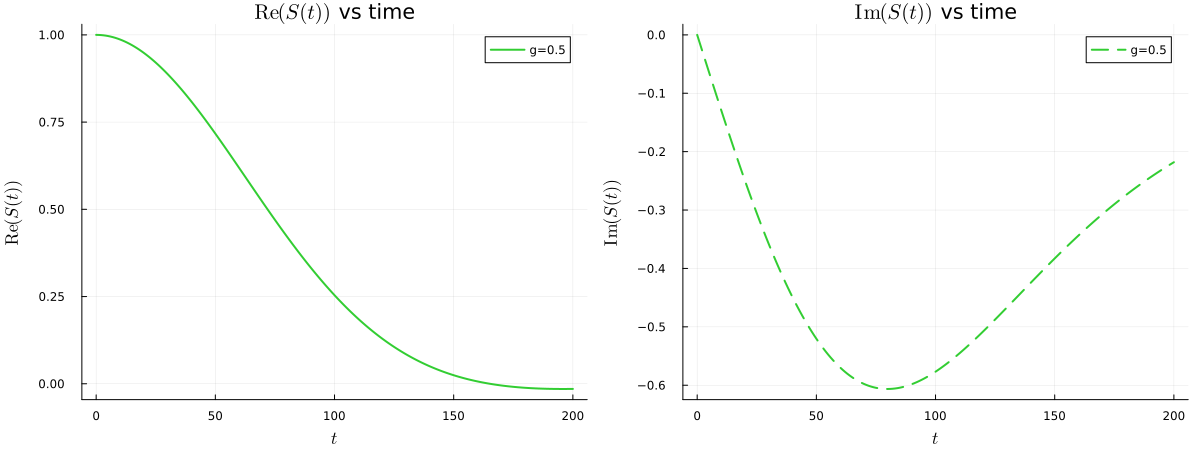

In [12]:
colors = ["lime green", "blue"]
Re_plt = plot()
for (i, g) in enumerate(g_list)
    Re_plt = plot!(
        t_range,
        real(S_t_list_g["g=$g"]);
        label = "g=$g",
        lw = 2,
        color = colors[i]
    )
end

Im_plt = plot()
for (i, g) in enumerate(g_list)
    Im_plt = plot!(
        t_range,
        imag(S_t_list_g["g=$g"]);
        label = "g=$g",
        lw = 2,
        ls = :dash,
        color = colors[i]
    )
end

plot(Re_plt, Im_plt, layout=(1,2), title=["\$\\mathrm{Re}(S(t))\$ vs time" "\$\\mathrm{Im}(S(t))\$ vs time"],
    guidefont=font(12),
    xlabel=["\$t\$" "\$t\$"],
    ylabel=["\$\\mathrm{Re}(S(t))\$" "\$\\mathrm{Im}(S(t))\$"],
    size=(1200, 450), 
    bottom_margin=18px,
    left_margin=22px)
#savefig("S(t) Plots/S(t), N=$N, m=23e-1, dp=417e-2")

### Calculate S(E)

In [13]:
function S(E::Real, S_t)
    dt = (2/a)/(length(t_range)-1)
    FTSoftFunc = 0
    for t in 1:(length(t_range)-1)
        f1 = exp(im*E*t_range[t])*S_t[t]
        f2 = exp(im*E*t_range[t+1])*S_t[t+1]
        FTSoftFunc += (dt/2)*(f1+f2)
    end
    return FTSoftFunc
end

S (generic function with 1 method)

In [24]:
E_range = -0.1:0.002:0.2
S_E_list_g = Dict()
for (i, g) in enumerate(g_list)
    S_E_list = ComplexF64[] #Create a temporary list for containing S(E) values for a given value of g
    S_E_list = [S(E, S_t_list_g["g=$g"]) for E in E_range] #Store S(E) for each value of E
    #= if haskey(SF_data_group["g=$g"], "S(E)") == false
        SF_data_group["g=$g"]["S(E)"] = S_E_list #Create a dataset containing the list of S(E) values at each energy E for a given value of g
    end =#
    S_E_list_g["g=$g"] = S_E_list
end

#Store the list of S(E) values into a dictionary 'keyed' by the corresponding value of g
#S_E_list_g = Dict("g=$g" => [SF_data_group["g=$g"]["S(E)"][i] for i in 1:length(E_range)] for g in g_list)

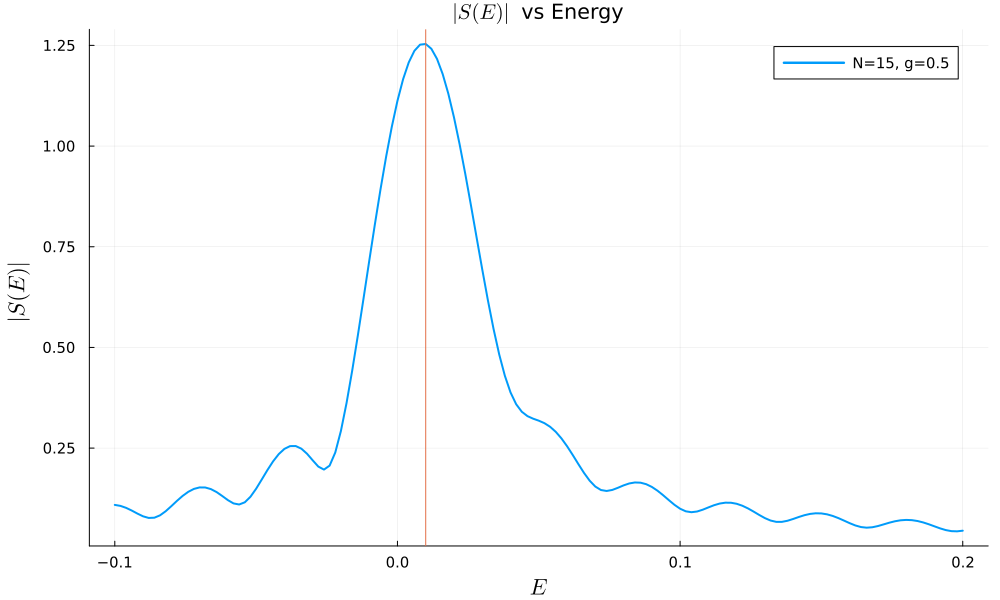

In [44]:
gr()
plot()
for g in g_list
    plot!(
        E_range,
        [abs(S_E_list_g["g=$g"][k]) for k in 1:length(E_range)];
        label = "N=$N, g=$g",
        lw =2
    )
end
vline!([E_range[argmax([abs(S_E_list_g["g=0.5"][k]) for k in 1:length(E_range)])]], label="")

xlabel!("\$E\$", guidefont=font(15))
ylabel!("\$|S(E)|\$", guidefont=font(15))
plot!(tickfontsize=10)
plot!(legendfontsize=10)
plot!(size = (1000, 600))
plot!(left_margin = 18px)
plot!(bottom_margin = 8px)
title!("\$|S(E)|\$ vs Energy")

#savefig("S(E) Plots/abs(S(E)), N x N=$N x $N, g=5e-1")

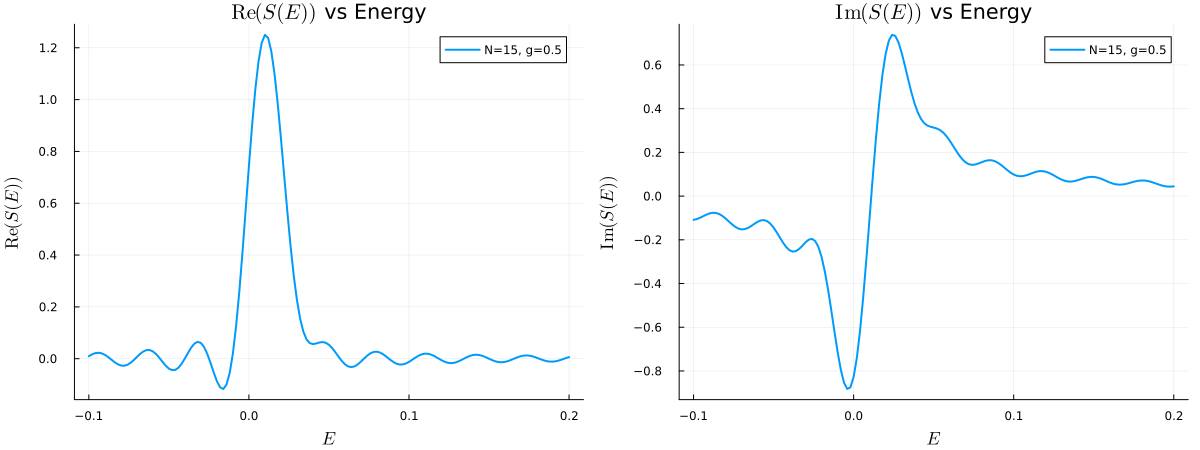

In [45]:
gr()
Re_plt = plot()
for g in g_list
    Re_plt = plot!(
        E_range,
        real(S_E_list_g["g=$g"]);
        label = "N=$N, g=$g",
        lw =2
    )
end

Im_plt = plot()
for g in g_list
    Im_plt = plot!(
        E_range,
        imag(S_E_list_g["g=$g"]);
        label = "N=$N, g=$g",
        lw =2
    )
end

plot(Re_plt, Im_plt, layout=(1,2), title=["\$\\mathrm{Re}(S(E))\$ vs Energy" "\$\\mathrm{Im}(S(E))\$ vs Energy"],
    guidefont=font(12),
    xlabel=["\$E\$" "\$E\$"],
    ylabel=["\$\\mathrm{Re}(S(E))\$" "\$\\mathrm{Im}(S(E))\$"],
    size=(1200, 450), 
    bottom_margin=18px,
    left_margin=22px)

#savefig("S(E) Plots/abs(S(E)), N x N=$N x $N, g=5e-1")